<a href="https://colab.research.google.com/github/deoashokanand/DSBA-6345-Spring-2022/blob/main/Ashok_Gensim_Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import re 
import numpy as np 
import pandas as pd 
from pprint import pprint

In [2]:
import gensim, spacy, logging, warnings

In [3]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words ('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
stop_words.extend(['from', '.',',','the','a','of','to','and','is', 'in', 'for',
                                  'an', ')', '(', 'with', 'or', 'by', 'first', 'from', 'that', 'on', 'to', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'na', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'br', 'sub', 'mech','non'])

In [6]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
df = pd.read_csv('/content/Telecommunication455.csv', encoding = 'unicode_escape')
print (df.shape)
df.head()

(15000, 10)


,PatentId,DatePublished,Assignee,Title,City,State,AbstractText,usClaimStatement,SubClass,FurtherClassification
0,06934508,20050823,Navigaug Inc.,System and method for obtaining comprehensive ...,Alpharetta,GA,A system apparatus method and computer progr...,NaN,2.01,455/ 3.01 455/ 3.04 455/428
1,06934509,20050823,NEC Corporation,Satellite broadcasting system capable of desig...,Tokyo,NaN,A satellite broadcasting system is disclosed w...,NaN,3.02,455/456 455/ 12.1 455/427 455/425 455/414.1 20...
2,06934510,20050823,Kabushiki Kaisha Asobou's,Watching method of baseball using mobile commu...,Tokyo,NaN,A baseball game spectating method is composed ...,NaN,3.06,455/899 348/ 14.01 348/157 348/517 725/ 38 725...
3,06934511,20050823,Andrew Corporation,Integrated repeater,Orland Park,IL,An integrated repeater includes a housing havi...,NaN,11.1,455/ 24 455/ 63.1 455/562.1 343/702 343/824
4,06934512,20050823,"Gilat Satellite Networks, Ltd.",Switching VSAT transmitter,Petah Tikvah,NaN,A VSAT terminal including an antenna a microw...,NaN,12.1,455/ 13.1 455/427


In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
df['AbstractText'] = df['AbstractText'].apply(str)
data = df.AbstractText.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['system', 'apparatus', 'method', 'and', 'computer', 'program', 'product', 'to', 'obtain', 'comprehensive', 'vehicle', 'radio', 'listener', 'statistics', 'based', 'on', 'parameters', 'such', 'as', 'radio', 'status', 'on', 'off', 'status', 'and', 'cd', 'tape', 'am', 'fm', 'setting', 'radio', 'volume', 'station', 'preset', 'information', 'current', 'frequency', 'setting', 'station', 'identification', 'and', 'global', 'positioning', 'satellite', 'gps', 'system', 'coordinates', 'is', 'disclosed', 'vehicle', 'mounted', 'field', 'unit', 'for', 'collecting', 'and', 'transmitting', 'such', 'parameters', 'to', 'base', 'station', 'is', 'also', 'disclosed', 'the', 'system', 'monitors', 'and', 'stores', 'all', 'events', 'related', 'to', 'the', 'occupants', 'interaction', 'with', 'the', 'vehicles', 'radio', 'including', 'automatic', 'detection', 'of', 'the', 'selected', 'radio', 'station', 'through', 'speaker', 'port', 'the', 'stored', 'data', 'is', 'then', 'transmitted', 'to', 'base', 'stations',

In [9]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
!python3 -m spacy download en_core_web_sm
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [11]:
data_ready = process_words(data_words)

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.052*"signal" + 0.028*"second" + 0.021*"input" + 0.021*"include" + '
  '0.018*"output" + 0.017*"frequency" + 0.014*"unit" + 0.012*"housing" + '
  '0.012*"provide" + 0.010*"couple"'),
 (1,
  '0.028*"station" + 0.028*"base" + 0.022*"receive" + 0.022*"signal" + '
  '0.020*"system" + 0.020*"power" + 0.019*"transmission" + 0.018*"transmit" + '
  '0.016*"communication" + 0.015*"determine"'),
 (2,
  '0.034*"device" + 0.028*"communication" + 0.028*"wireless" + 0.025*"mobile" '
  '+ 0.024*"network" + 0.023*"information" + 0.021*"system" + 0.019*"user" + '
  '0.014*"terminal" + 0.014*"include"')]


In [13]:
!pip install pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

     |████████████████████████████████| 1.7 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4360ea52952f45b409a6ef1eaa2b0253838aff0f29eee5a6d771dc82fd57be7a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
2     -0.17541  0.157399       1        1  43.718268
1     -0.08844 -0.196256       2        1  31.877536
0      0.26385  0.038857       3        1  24.404196, topic_info=         Term          Freq         Total Category  logprob  loglift
151    signal  16450.000000  16450.000000  Default  30.0000  30.0000
52    station   7866.000000   7866.000000  Default  29.0000  29.0000
231   network   8752.000000   8752.000000  Default  28.0000  28.0000
209    device  14171.000000  14171.000000  Default  27.0000  27.0000
7        base   9408.000000   9408.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
225   control   2054.238774   6912.026010   Topic3  -4.6028   0.1971
89    receive   2047.523911  11205.267360   Topic3  -4.6060  -0.2893
164     power   1542.776819   6934.499513   Topic3  -4.8891  -0.0925
209    device   1639.389699  14171.978048   Topic3  -4.8283  -0.7465
175  comprise   1283.127868   3114.829309   Topic3  -5.0734   0.5235

[193 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
433       1  0.999810    access
433       2  0.000254    access
506       1  0.998834   address
221       2  0.998915    amount
221       3  0.001659    amount
...     ...       ...       ...
1152      1  0.998978     video
634       1  0.999163     voice
1019      3  0.999509   voltage
410       1  0.832337  wireless
410       2  0.167659  wireless

[222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

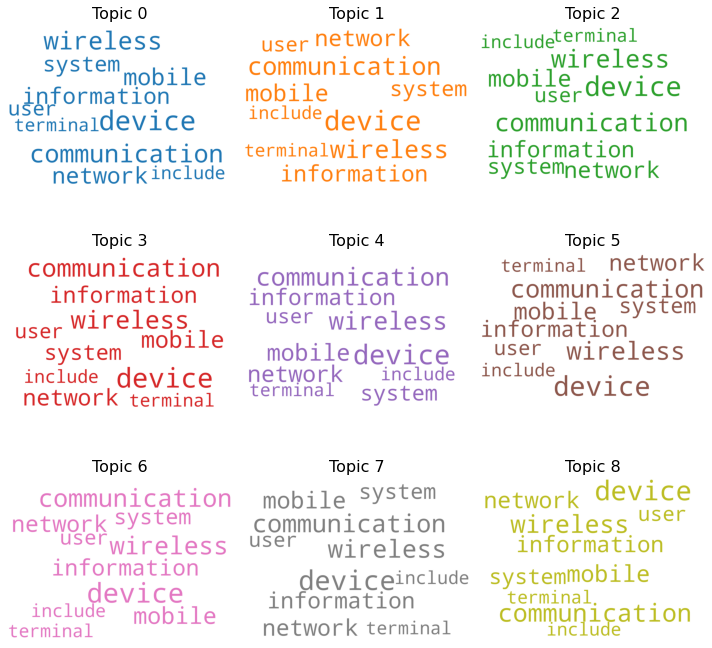

In [16]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    #topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [17]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -6.614502700672141


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for